The below cell contains all the constants used in rest of the codes

# Constants

In [1]:
"""
Created on Thu Feb 20 08:22:30 2020

@author: Saba
"""

HOME_DIR = "/home/ubuntu/"


INPUT = HOME_DIR + "Dataset/fields_with_masks/"


BACK_BONE = 'efficientnetb5'
BATCH_SIZE = 2
Defined_CLASSES = [1]
LR = 0.0001
EPOCHS = 200

import keras

OPTIMIZER = keras.optimizers.Adam(LR)

Using TensorFlow backend.


# Data_loader and Utility_function cell

In [2]:
import matplotlib.pyplot as plt
from io import BytesIO
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import re

import tensorflow as tf
import keras
from keras.backend.tensorflow_backend import set_session  

os.environ['CUDA_VISIBLE_DEVICES'] = '2, 3'
config =  tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
set_session(sess)

""" This function used to visualize the input, predicted mask and ground truth"""
def visualize(save_status, save_path,flight_code,**images ):
    
    n = len(images)
    plt.figure(figsize=(40,40))
    for i, (name , image) in enumerate(images.items()):
        plt.subplot(1, n, i+1)
        plt.xticks([])
        plt.yticks([])
        # plt.title(str(i+1))
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
        
    
    if save_status : 
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        plt.savefig(save_path+flight_code+'.jpg')    
    plt.show()
    
    
def denormalize(x):
    x_max = np.max(x)
    x_min = np.min(x)
    x = (x-x_min) / (x_max - x_min)
    x = x.clip(0,1)
    return x

def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key,reverse=True)    

class Dataset:
    
    CLASSES = Defined_CLASSES
    def __init__(
            self,
            field_dir,
            status, #train,test,validation
            classes = None,
            augmentation = None,
            preprocessing = None
            ):
        """ make a list of image directions  """
        files = ['bounday_mask.png','nutrient_mask.png']#,'ndvi.png','gndvi.png','ndwi.png']
        self.field_dirs = [ids for ids in sorted(os.listdir(field_dir))]
        self.field_fps = [os.path.join(field_dir ,field_id) for field_id in self.field_dirs if len(os.listdir(os.path.join(field_dir ,field_id))) >= 3 ]
        
        train, validate, test = np.split(self.field_fps, [int(.6*len(self.field_fps)), int(.8*len(self.field_fps))])
        print(len(train))
        print(len(validate))
        print(len(test))
        if status == 'train':
            self.field_fps = train
        elif status == 'validate':
            self.field_fps = validate
        elif status == 'test':
            self.field_fps = test
        
        self.field_codes            = []
        self.field_number            = []
        self.field_images            = []
        self.field_nutrient_mask     = []
        self.field_boundary_mask     = []

        for field_path in self.field_fps:
            flight_dirs = sorted_alphanumeric(os.listdir(field_path))
            codes  = []
            number = []
            images = []
            nutrient_mask = []
            boundary_mask = []

            for j in flight_dirs:
                flight_number, flight_code = j.split('_')
                codes.append(flight_code)
                number.append(flight_number)
                images.append(os.path.join(field_path,j,flight_code+'.png'))
                boundary_mask.append(os.path.join(field_path,j,files[0]))
                nutrient_mask.append(os.path.join(field_path,j,files[1]))


            self.field_codes.append(codes)
            self.field_number.append(number)
            self.field_images.append(images)
            self.field_nutrient_mask.append(nutrient_mask)
            self.field_boundary_mask.append(boundary_mask)

        
        """ set the class values and assign a augmentation and preprocessing method"""
        # self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.class_values = classes
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def __getitem__(self,i):
         
        """ read images"""
        image1 = cv2.imread(self.field_images[i][0])
        image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
        w, h,_ = image1.shape
        
        
        
        image2 = cv2.imread(self.field_images[i][1])
        image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
        image2 = cv2.resize(image2, (h,w) , interpolation = cv2.INTER_AREA)
        
        
        image3 = cv2.imread(self.field_images[i][2])
        image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)
        image3 = cv2.resize(image3, (h,w), interpolation = cv2.INTER_AREA)
        
        
        boundary_mask = cv2.imread(self.field_boundary_mask[i][0])
        boundary_mask = cv2.cvtColor(boundary_mask, cv2.COLOR_BGR2GRAY)
        
        
        nutrient_mask = cv2.imread(self.field_nutrient_mask[i][0])
        nutrient_mask = cv2.cvtColor(nutrient_mask, cv2.COLOR_BGR2GRAY) 
        
        boundary_mask = denormalize(boundary_mask)
        nutrient_mask = denormalize(nutrient_mask)

#         image1 = (image1*boundary_mask).astype(np.uint8) 
#         image2 = (image2*boundary_mask).astype(np.uint8) 
#         image3 = (image3*boundary_mask).astype(np.uint8) 
        
        """ extract certain classes from mask 1 """
        masks = [(boundary_mask == v) for v in self.class_values]
        boundary_mask = np.stack(masks, axis = -1).astype('float')
        
        boundary_mask_for_slic = np.stack(masks, axis = 0).astype('float')
        
        masks = [(nutrient_mask == v) for v in self.class_values]
        nutrient_mask = np.stack(masks, axis = -1).astype('float')
        
        data1 = {"image": image1,"image2": image2, "image3": image3, "mask": nutrient_mask }
        """ apply augmentation """
        if self.augmentation:
            sample = self.augmentation(**data1)
            image1 , nutrient_mask, image2, image3 = sample['image'], sample['mask'], sample['image2'], sample['image3'] 
         
        data2 = {"image": image1,"image2": image2, "image3": image3, "mask": nutrient_mask }
        """ apply preprocessing """
        if self.preprocessing:
            sample = self.preprocessing(**data2)
            image1 , nutrient_mask,image2,image3 = sample['image'], sample['mask'], sample['image2'],sample['image3']
        #A1, labels1,X1,y1 = super_pixels(image=image1, mask=boundary_mask_for_slic1, nutrient_mask=nutrient_mask1, prev_labels = None)
        #A2, labels2,X2,y2 = super_pixels(image=image2, mask=boundary_mask_for_slic2, nutrient_mask=nutrient_mask2, prev_labels = labels1)
             
        #return image, nutrient_mask, self.image_dirs[i]
        return image1, image2, image3,nutrient_mask, boundary_mask,self.field_codes[i][0] 
    
    def __len__(self):
        return len(self.field_images)
class Dataloader(keras.utils.Sequence):
    
    def __init__(
            self,
            dataset,
            batch_size = 1,
            shuffle = False
            ):
        
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
        
        self.on_epoch_end()
        
    def __getitem__(self, i):
        
        start = i * self.batch_size
        stop = (i+1) * self.batch_size
        data = []
        for j in range(start, stop):
            #data.append([self.dataset[j][0],self.dataset[j][0]],self.dataset[j][1])
            im1,im2,im3,mask,_,_ = self.dataset[j]
            image_tot = np.concatenate((im1,im2,im3),axis =2)
            data.append((image_tot,mask))
            
        batch = [np.stack(samples, axis = 0) for samples in zip(*data)]

        return batch            
    
    def __len__(self):
        """  the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)            

# Do Data Augmentation

In [12]:
import albumentations as A


def round_clip_0_1(x, **kwargs):
    return x.round

def training_augmentation():
        train_transform = [
            A.HorizontalFlip(p = 0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(scale_limit = 0.5, rotate_limit=0, shift_limit = 0.1, p = 1, border_mode=0),
            A.PadIfNeeded(min_height = 512, min_width = 512, always_apply= True, border_mode=0),
            #A.RandomCrop(height=512, width=512, always_apply = True),
            A.CropNonEmptyMaskIfExists(height=512, width=512,always_apply = True),
            #A.RandomResizedCrop(height, width, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1, always_apply=False, p=1.0)
            #A.Resize(height=672, width=672, interpolation=1, always_apply=True, p=1),
            A.IAAAdditiveGaussianNoise(p=0.2),
            A.IAAPerspective(p=0.5),

            A.OneOf(
               [
                   A.CLAHE(p=1),
                   A.RandomBrightness(p=1),
                   A.RandomGamma(p=1),
               ],
               p=0.9,
            ),

            A.OneOf(
               [
                   A.IAASharpen(p=1),
                   A.Blur(blur_limit=3, p=1),
                   A.MotionBlur(blur_limit=3, p=1),
               ],
               p=0.9,
            ),

            A.OneOf(
               [
                   A.RandomContrast(p=1),
                   A.HueSaturationValue(p=1),
               ],
               p=0.9,
           ),
            # A.Lambda(mask = round_clip_0_1)
            #A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, shadow_dimension=5, always_apply=False, p=0.5)
        ]
    
        return A.Compose(train_transform,
            additional_targets={"image2" : "image", "image3":"image"})

def validation_augmentation():
    test_transform = [
        A.PadIfNeeded(min_height = 512, min_width = 512, always_apply= True, border_mode=0),
        A.CropNonEmptyMaskIfExists(height=512, width=512, always_apply=True)
        #A.RandomCrop(height=512, width=512, always_apply = True)
        #A.Resize(height=512, width=512, interpolation=1, always_apply=True, p=1)
        ]
    return A.Compose(test_transform,additional_targets={"image2" : "image", "image3":"image"})

def get_preprocessing(preprocessing_fn):
    
    _transform = [
        A.Lambda(image = preprocessing_fn),
        ]
    return A.Compose(_transform,additional_targets={"image2" : "image", "image3":"image"})

# BASE_MODEL

In [4]:
import segmentation_models as sm
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras import Model
from keras.layers import Input, Conv2D


""" define preprocess method condisering back_bone"""
preprocess_input = sm.get_preprocessing(BACK_BONE)

""" model parameters"""
n_classes = 1 if len(Defined_CLASSES)== 1 else (len(Defined_CLASSES)+1)
activation = 'sigmoid' if n_classes == 1 else 'softmax'


"""creating a model"""
model = sm.Unet(BACK_BONE, classes = n_classes, activation = activation, encoder_weights='imagenet',encoder_freeze = False)


model.layers.pop(0)
newInputs = Input(shape=(None,None,9))
x = Conv2D(3, kernel_size=(1,1))(newInputs)
newOutputs = model(x)
model = Model(newInputs, newOutputs)

model.summary()
""" defining loss function and metrics"""
#dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.1,0.3,0.7,0.9])) 
#focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
#total_loss = dice_loss + (1 * focal_loss)
total_loss = sm.losses.binary_focal_dice_loss

metrics = [sm.metrics.IOUScore(threshold =0.5), sm.metrics.FScore(threshold = 0.5)]

""" compiling the network """
model.compile(OPTIMIZER, total_loss, metrics)

Segmentation Models: using `keras` framework.









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 9)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 3)     30        
_________________________________________________________________
model_1 (Model)              (None, None, None, 1)     37468673  
Total params: 37,468,703
Trainable params: 37,293,983
Non-trainable params: 174,720
_________________________________________________________________




In [5]:
""" loading traind and validation dataset """
train_dataset = Dataset(INPUT,
                        status = 'train',
                           classes = Defined_CLASSES,
                           augmentation = training_augmentation(),
                           preprocessing = get_preprocessing(preprocess_input),
                           )

valid_dataset = Dataset(INPUT,
                        status = 'validate',
                           classes = Defined_CLASSES,
                           augmentation = training_augmentation(),
                           preprocessing = get_preprocessing(preprocess_input),
                           )

train_dataloader = Dataloader(train_dataset, batch_size = BATCH_SIZE, shuffle = True )
valid_dataloader = Dataloader(valid_dataset, batch_size = 1, shuffle = False )

231
77
78
231
77
78


Train the MODEL

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/200
 77/115 [===================>..........] - ETA: 1:18 - loss: 1.0465 - iou_score: 0.0892 - f1-score: 0.1547

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in true_divide


115/115 [==============================] - 225s 2s/step - loss: 1.0237 - iou_score: 0.0911 - f1-score: 0.1565 - val_loss: 0.9997 - val_iou_score: 0.0700 - val_f1-score: 0.1204
Epoch 2/200
115/115 [==============================] - 147s 1s/step - loss: 0.9268 - iou_score: 0.1115 - f1-score: 0.1924 - val_loss: 0.9436 - val_iou_score: 0.0934 - val_f1-score: 0.1574
Epoch 3/200
115/115 [==============================] - 147s 1s/step - loss: 0.8973 - iou_score: 0.1487 - f1-score: 0.2459 - val_loss: 0.9438 - val_iou_score: 0.1169 - val_f1-score: 0.1841
Epoch 4/200
115/115 [==============================] - 147s 1s/step - loss: 0.8827 - iou_score: 0.1795 - f1-score: 0.2872 - val_loss: 0.9309 - val_iou_score: 0.1229 - val_f1-score: 0.1961
Epoch 5/200
115/115 [==============================] - 147s 1s/step - loss: 0.8601 - iou_score: 0.1914 - f1-score: 0.3034 - val_loss: 0.8919 - val_iou_score: 0.1539 - val_f1-score: 0.2367
Epoch 6/200
115/115 [==============================] - 147s 1s/step - lo

115/115 [==============================] - 147s 1s/step - loss: 0.6000 - iou_score: 0.3504 - f1-score: 0.4976 - val_loss: 0.7879 - val_iou_score: 0.2323 - val_f1-score: 0.3303
Epoch 45/200
115/115 [==============================] - 147s 1s/step - loss: 0.5821 - iou_score: 0.3604 - f1-score: 0.5120 - val_loss: 0.7785 - val_iou_score: 0.2263 - val_f1-score: 0.3186
Epoch 46/200
115/115 [==============================] - 147s 1s/step - loss: 0.5936 - iou_score: 0.3582 - f1-score: 0.5062 - val_loss: 0.7668 - val_iou_score: 0.2275 - val_f1-score: 0.3206
Epoch 47/200
115/115 [==============================] - 147s 1s/step - loss: 0.6015 - iou_score: 0.3493 - f1-score: 0.4936 - val_loss: 0.7478 - val_iou_score: 0.2541 - val_f1-score: 0.3527
Epoch 48/200
115/115 [==============================] - 147s 1s/step - loss: 0.5852 - iou_score: 0.3663 - f1-score: 0.5137 - val_loss: 0.7218 - val_iou_score: 0.2746 - val_f1-score: 0.3759
Epoch 49/200
115/115 [==============================] - 147s 1s/step

115/115 [==============================] - 147s 1s/step - loss: 0.5569 - iou_score: 0.3865 - f1-score: 0.5357 - val_loss: 0.7223 - val_iou_score: 0.2822 - val_f1-score: 0.3910
Epoch 88/200
115/115 [==============================] - 147s 1s/step - loss: 0.5606 - iou_score: 0.3783 - f1-score: 0.5309 - val_loss: 0.7455 - val_iou_score: 0.2480 - val_f1-score: 0.3547
Epoch 89/200
115/115 [==============================] - 147s 1s/step - loss: 0.5692 - iou_score: 0.3716 - f1-score: 0.5189 - val_loss: 0.7047 - val_iou_score: 0.2694 - val_f1-score: 0.3784
Epoch 90/200
115/115 [==============================] - 147s 1s/step - loss: 0.5808 - iou_score: 0.3667 - f1-score: 0.5132 - val_loss: 0.7666 - val_iou_score: 0.2269 - val_f1-score: 0.3285
Epoch 91/200
115/115 [==============================] - 147s 1s/step - loss: 0.5604 - iou_score: 0.3850 - f1-score: 0.5388 - val_loss: 0.7549 - val_iou_score: 0.2115 - val_f1-score: 0.3162
Epoch 92/200
115/115 [==============================] - 147s 1s/step

115/115 [==============================] - 147s 1s/step - loss: 0.5441 - iou_score: 0.3964 - f1-score: 0.5491 - val_loss: 0.7691 - val_iou_score: 0.2314 - val_f1-score: 0.3333
Epoch 131/200
115/115 [==============================] - 147s 1s/step - loss: 0.5827 - iou_score: 0.3655 - f1-score: 0.5104 - val_loss: 0.7733 - val_iou_score: 0.2065 - val_f1-score: 0.2992
Epoch 132/200
115/115 [==============================] - 147s 1s/step - loss: 0.5557 - iou_score: 0.3846 - f1-score: 0.5388 - val_loss: 0.7704 - val_iou_score: 0.2297 - val_f1-score: 0.3249
Epoch 133/200
115/115 [==============================] - 147s 1s/step - loss: 0.5585 - iou_score: 0.3809 - f1-score: 0.5342 - val_loss: 0.7441 - val_iou_score: 0.2607 - val_f1-score: 0.3594
Epoch 134/200
115/115 [==============================] - 147s 1s/step - loss: 0.5711 - iou_score: 0.3738 - f1-score: 0.5227 - val_loss: 0.7543 - val_iou_score: 0.2377 - val_f1-score: 0.3389
Epoch 135/200
115/115 [==============================] - 147s 1s

115/115 [==============================] - 147s 1s/step - loss: 0.5793 - iou_score: 0.3649 - f1-score: 0.5126 - val_loss: 0.7413 - val_iou_score: 0.2586 - val_f1-score: 0.3662
Epoch 174/200
115/115 [==============================] - 147s 1s/step - loss: 0.5589 - iou_score: 0.3806 - f1-score: 0.5318 - val_loss: 0.7538 - val_iou_score: 0.2633 - val_f1-score: 0.3680
Epoch 175/200
115/115 [==============================] - 148s 1s/step - loss: 0.5545 - iou_score: 0.3851 - f1-score: 0.5351 - val_loss: 0.7738 - val_iou_score: 0.2207 - val_f1-score: 0.3183
Epoch 176/200
115/115 [==============================] - 147s 1s/step - loss: 0.5643 - iou_score: 0.3744 - f1-score: 0.5255 - val_loss: 0.7555 - val_iou_score: 0.2510 - val_f1-score: 0.3587
Epoch 177/200
115/115 [==============================] - 147s 1s/step - loss: 0.5788 - iou_score: 0.3626 - f1-score: 0.5129 - val_loss: 0.7608 - val_iou_score: 0.2589 - val_f1-score: 0.3566
Epoch 178/200
115/115 [==============================] - 147s 1s

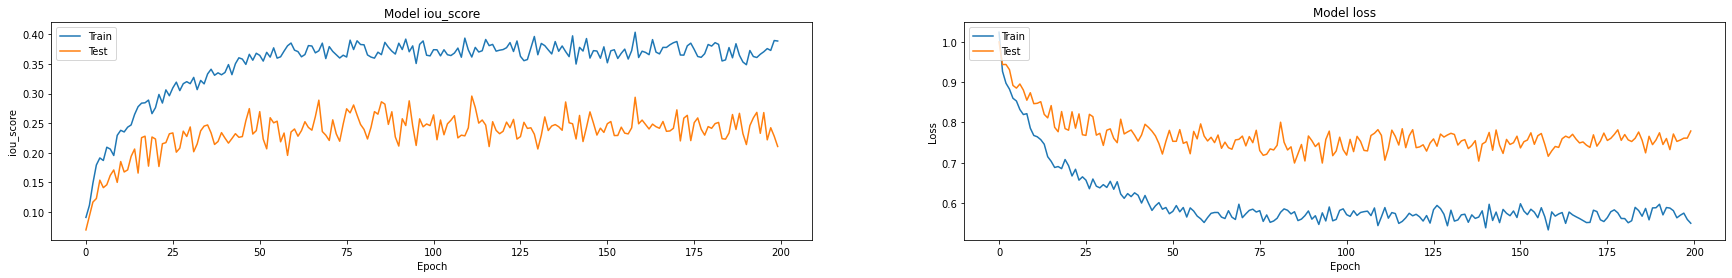

In [6]:
"""check shapes for errors"""
#assert train_dataloader[0][0].shape == (BATCH_SIZE, 512, 512, 3)
#assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 512, n_classes)

""" define callbacks  for learning rate scheduling and best checkpoints """

callbacks = [
    keras.callbacks.ModelCheckpoint('/home/ubuntu/Trained_model/Unet_segmentaion_'+BACK_BONE+'_batch_'+str(BATCH_SIZE)+'_epoch_'+str(EPOCHS)+'_3_time_steps_9_channels'+'.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    ]

history = model.fit_generator(
    train_dataloader,
    steps_per_epoch = len(train_dataloader),
    epochs = EPOCHS,
    callbacks = callbacks,
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
    )



""" Plot training & validation iou_score values """
plt.figure(figsize=(30, 4))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

""" Plot training & validation loss values """
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()
plt.savefig('training_loss_IOU_'+BACK_BONE+'_batch_'+str(BATCH_SIZE)+'_epoch_'+str(EPOCHS)+'_3_time_steps_9_channels'+'.png')

231
77
78
Loss: 0.62354
mean iou_score: 0.34531
mean f1-score: 0.47899


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1YBBHAHIC


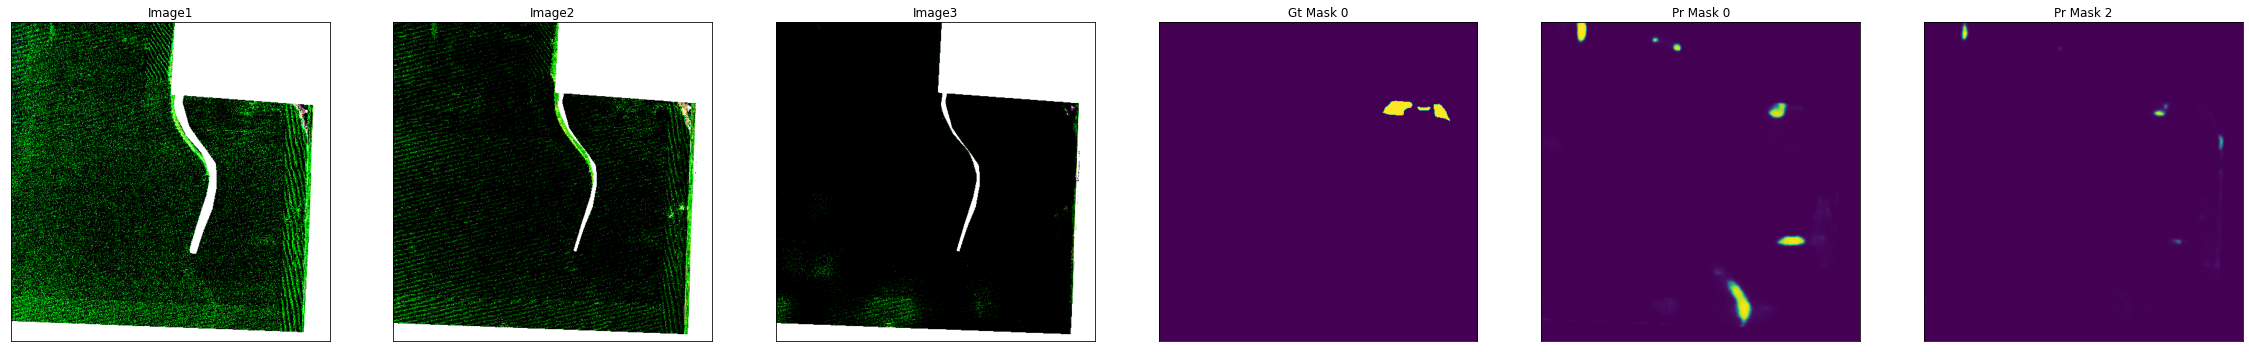

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KRCZYQMUT


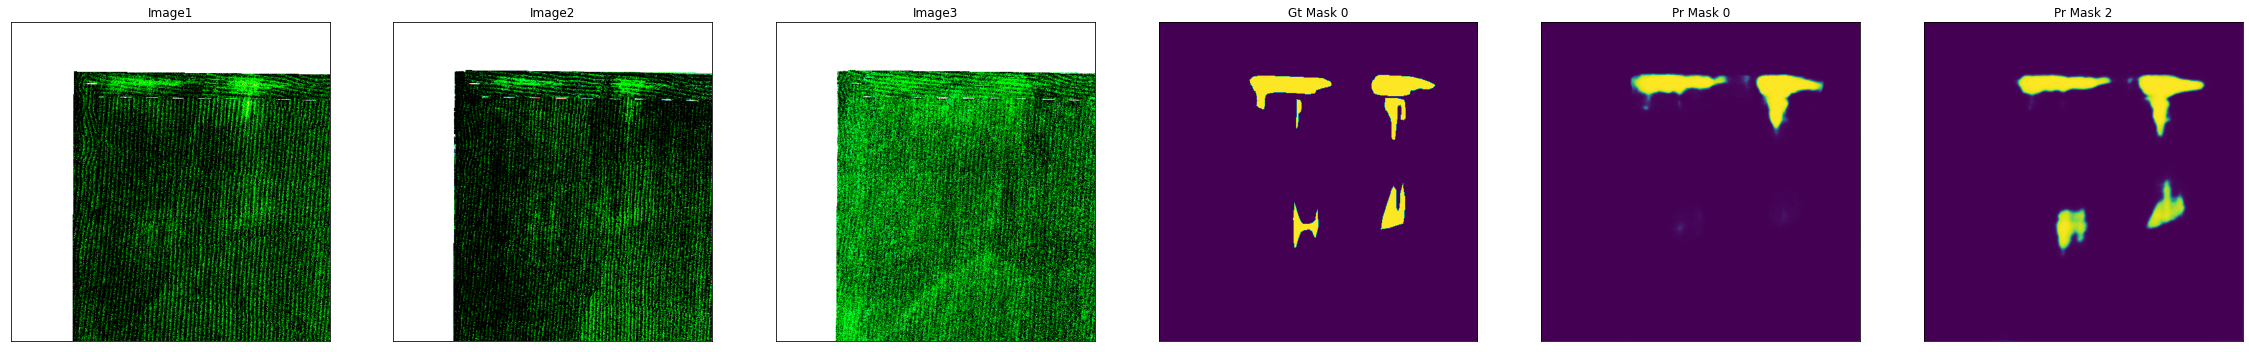

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


P6Z1D4II6


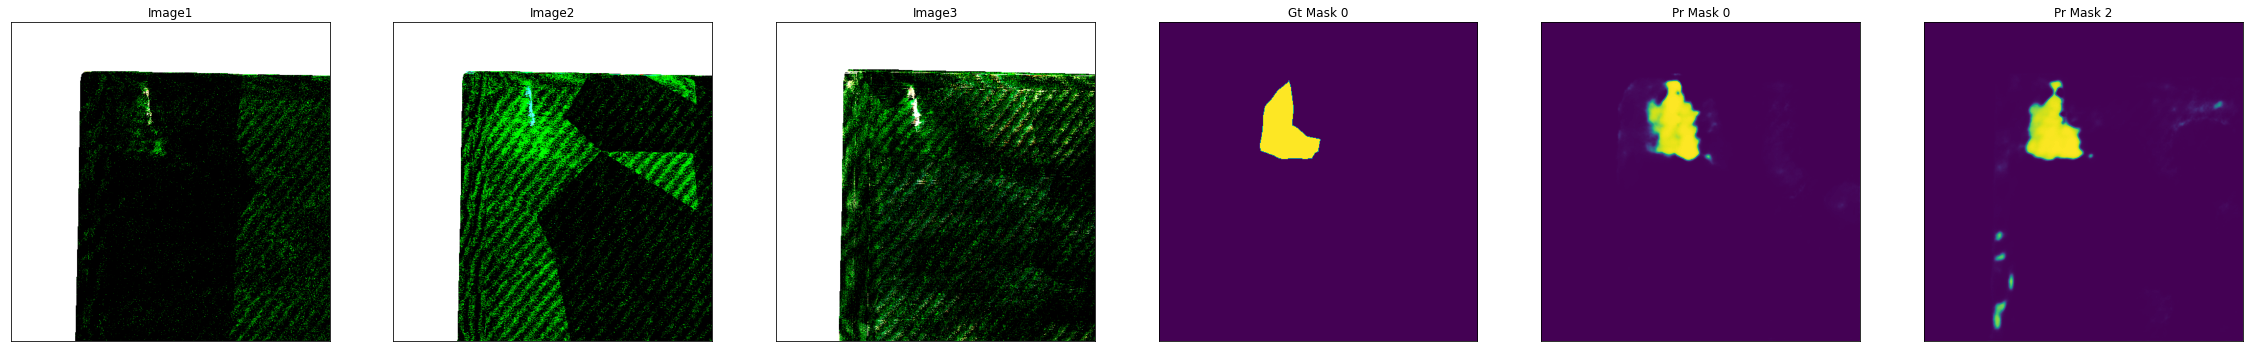

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


34VURFGJY


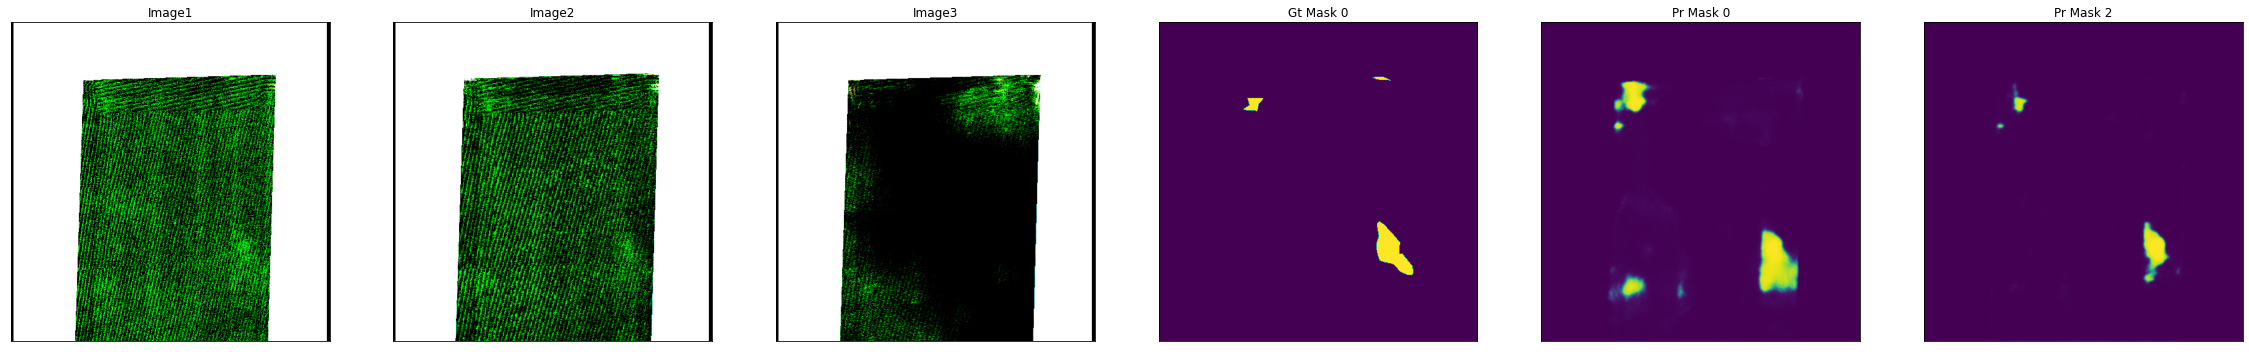

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


W3JYY6WMI


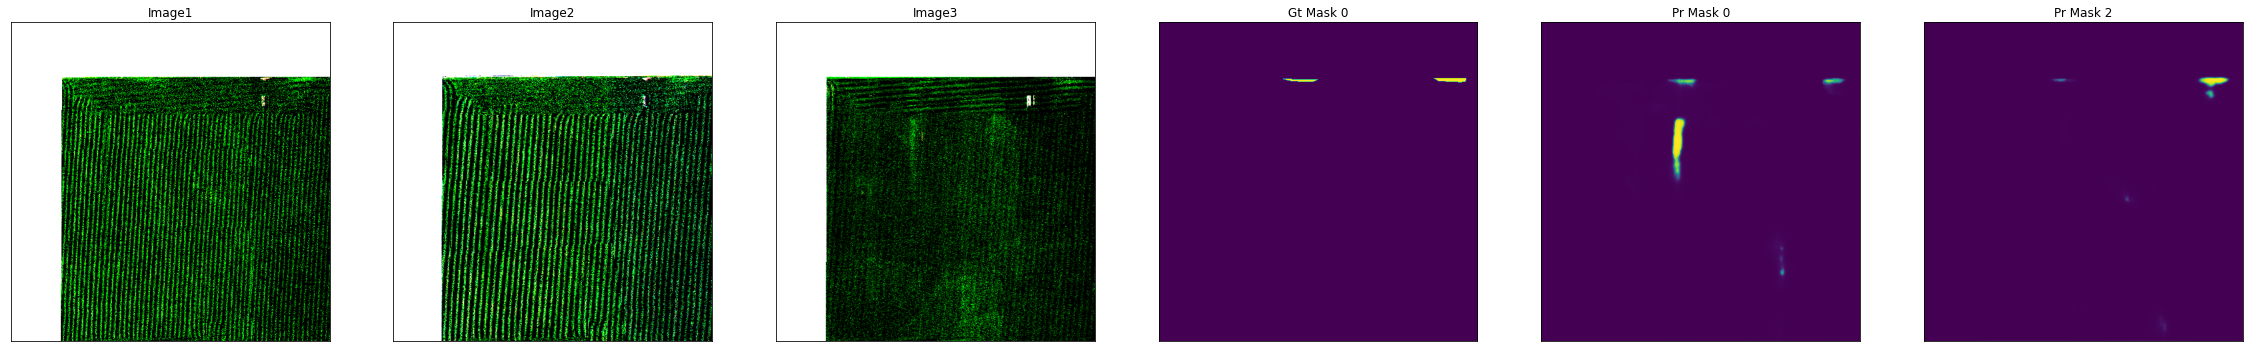

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1GYFAWLYU


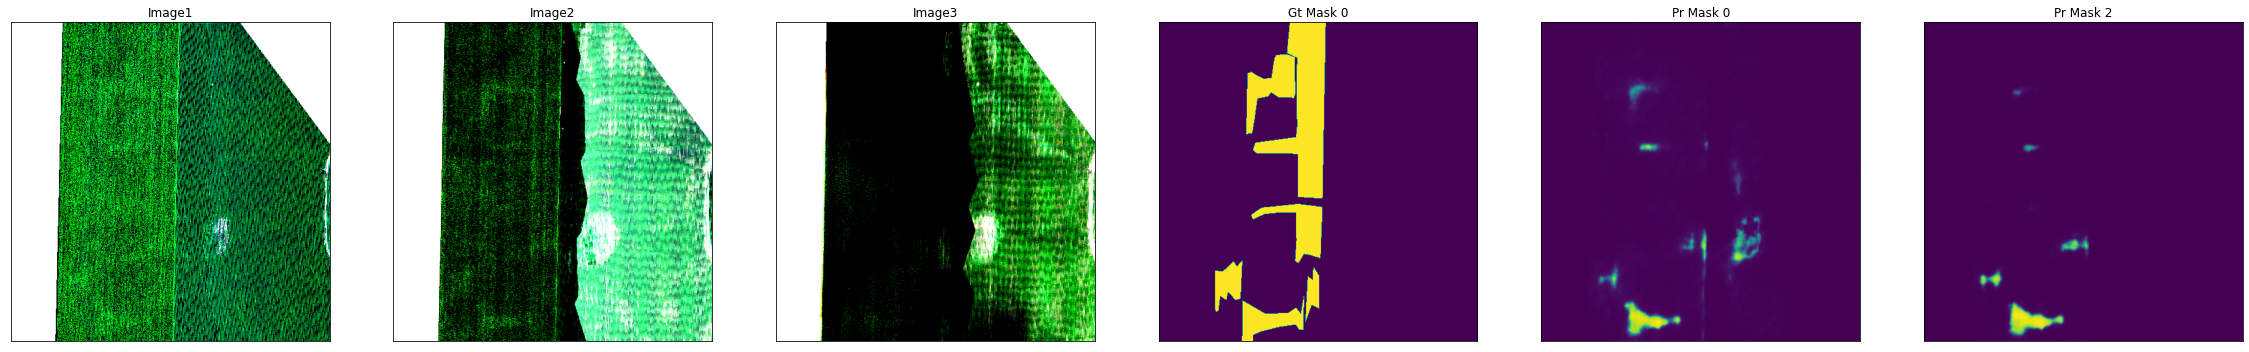

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


P17EGB63M


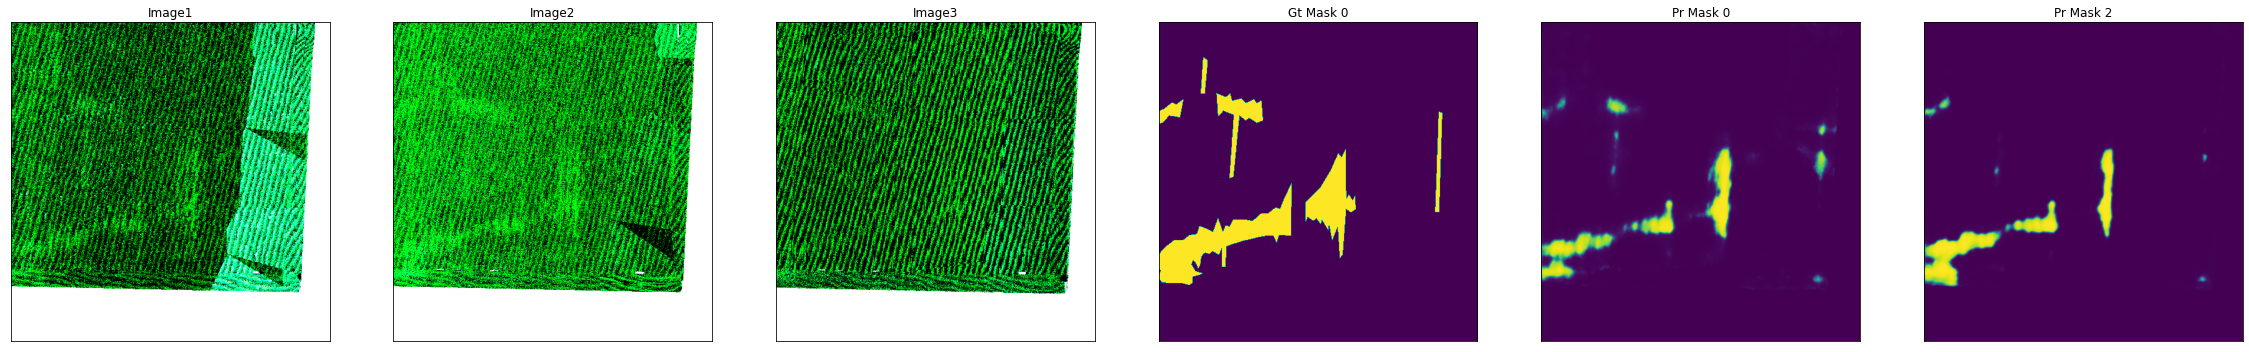

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


WZ2ECYMQT


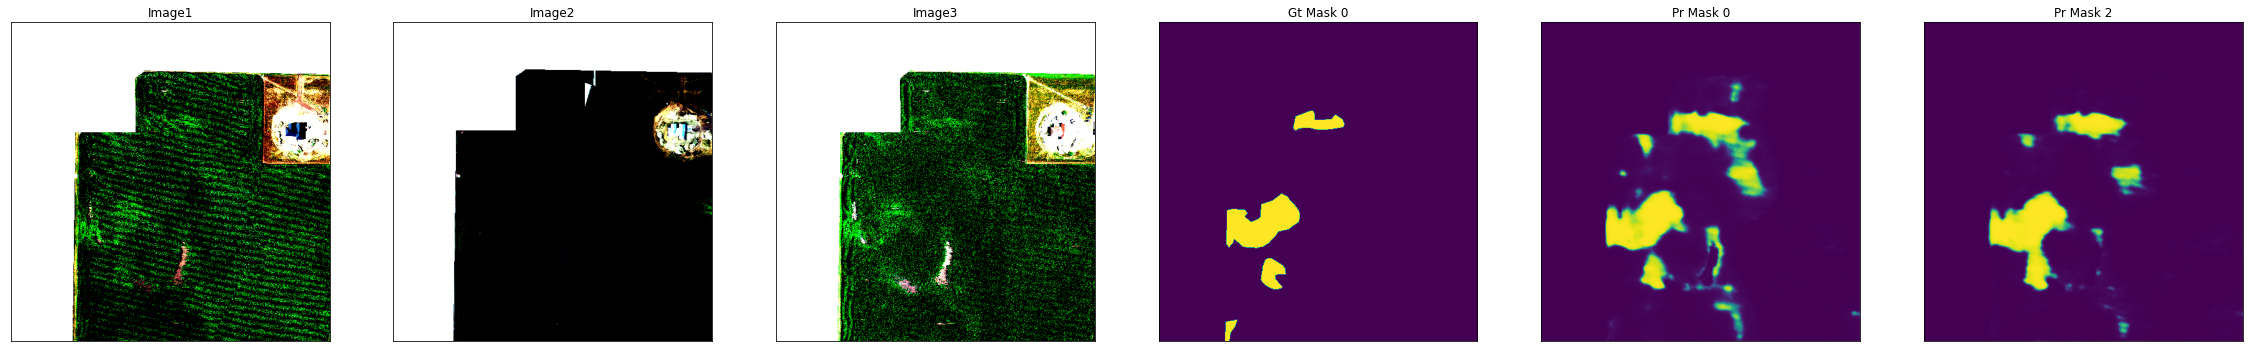

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


FJFFLYRLD


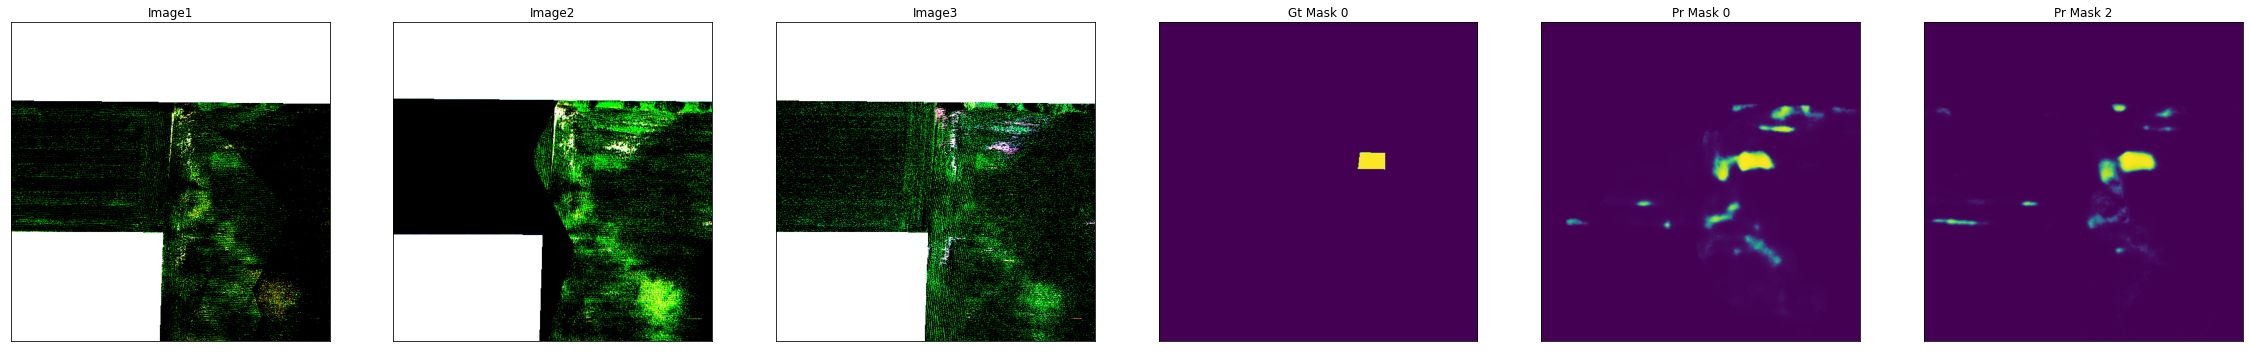

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AMBEDAYEG


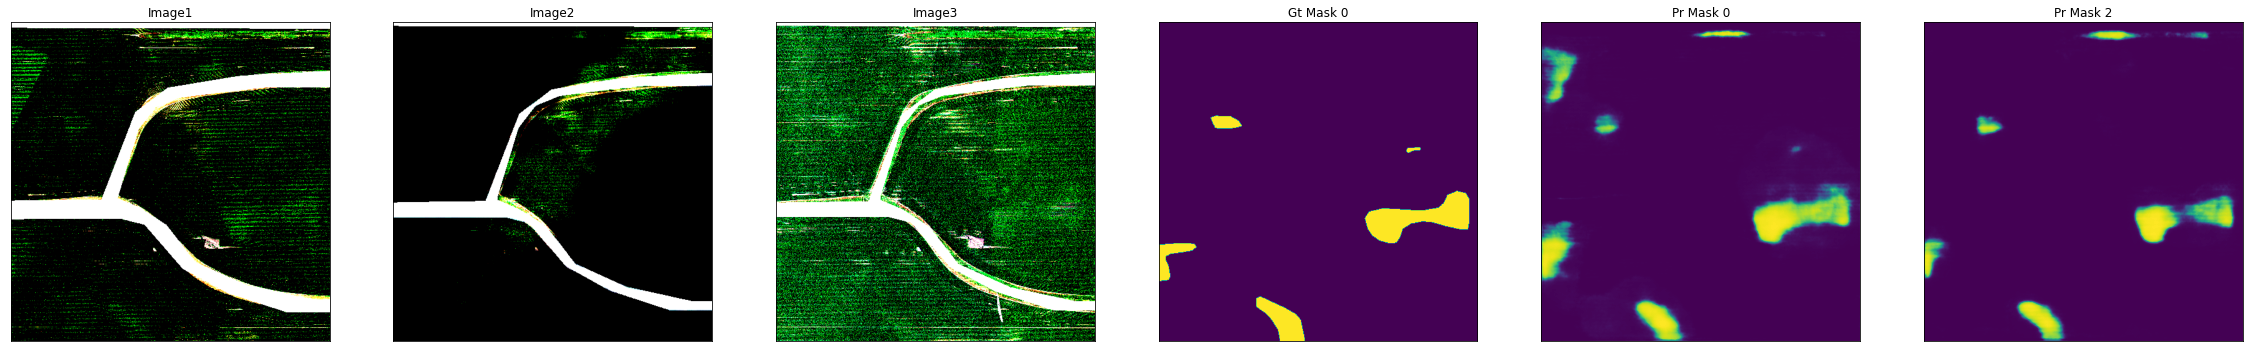

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ABFZ34386


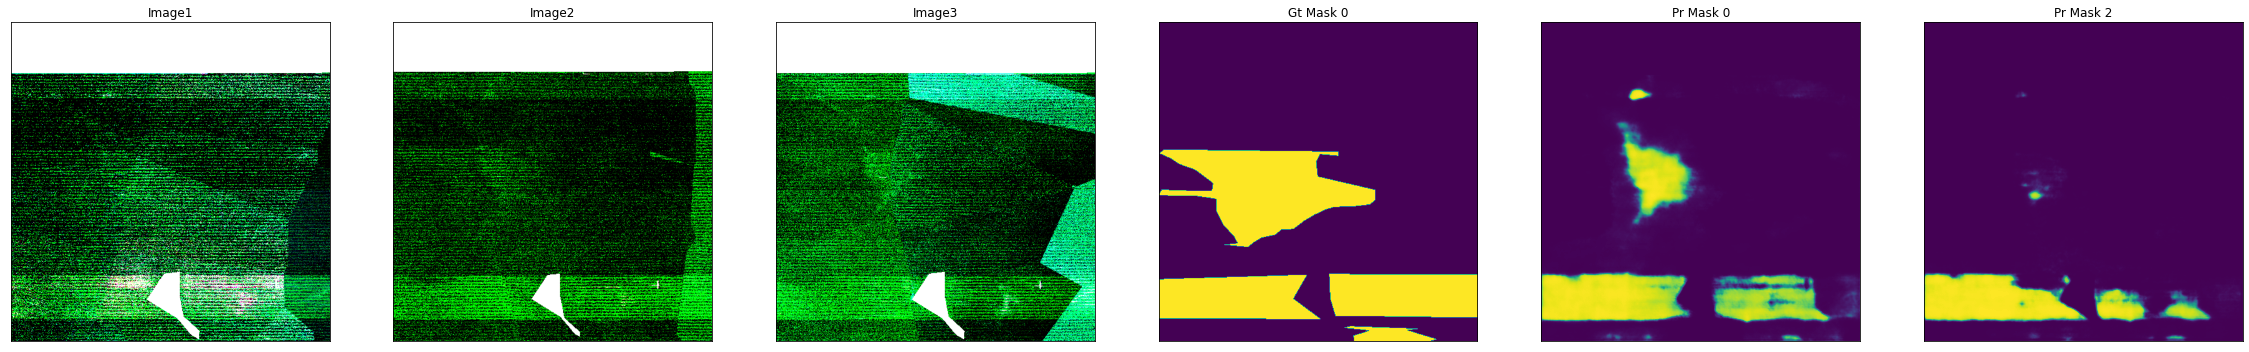

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


U2AVGC8PH


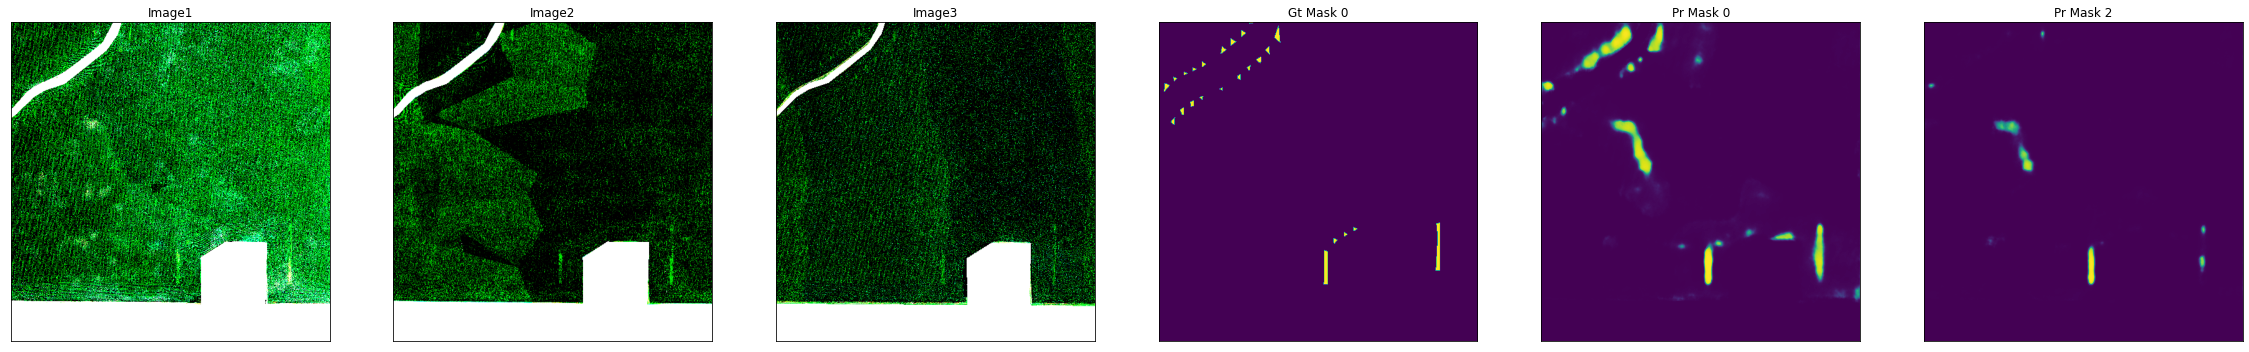

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


B1HX364VH


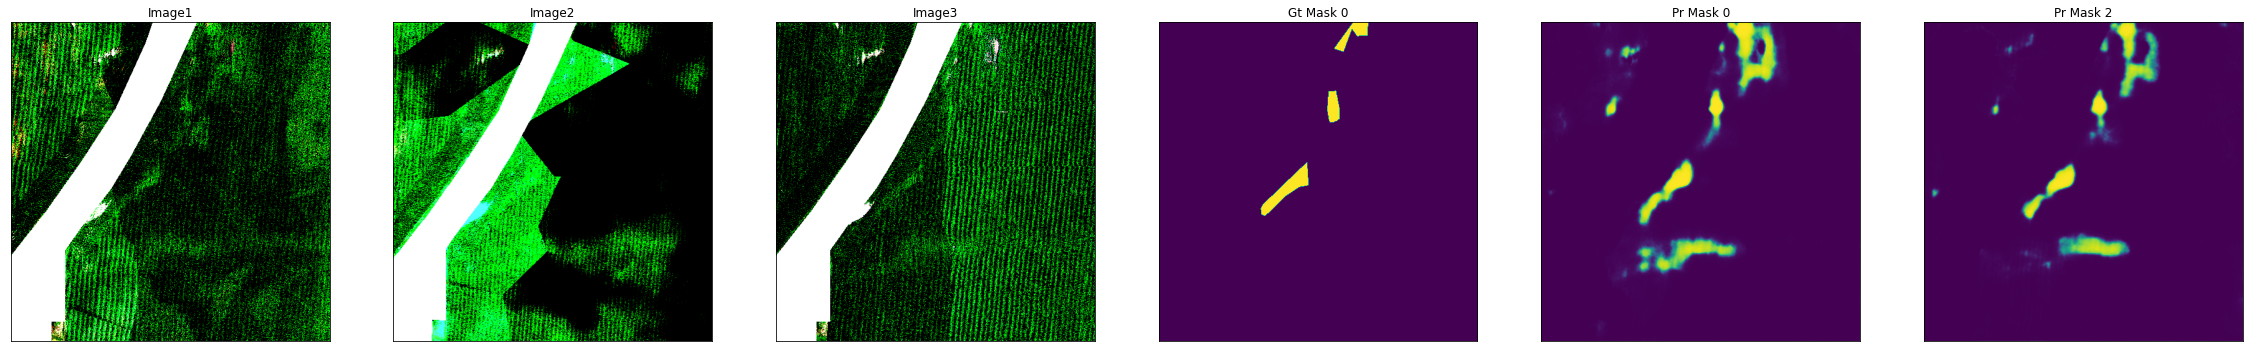

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


XLV9P2UZC


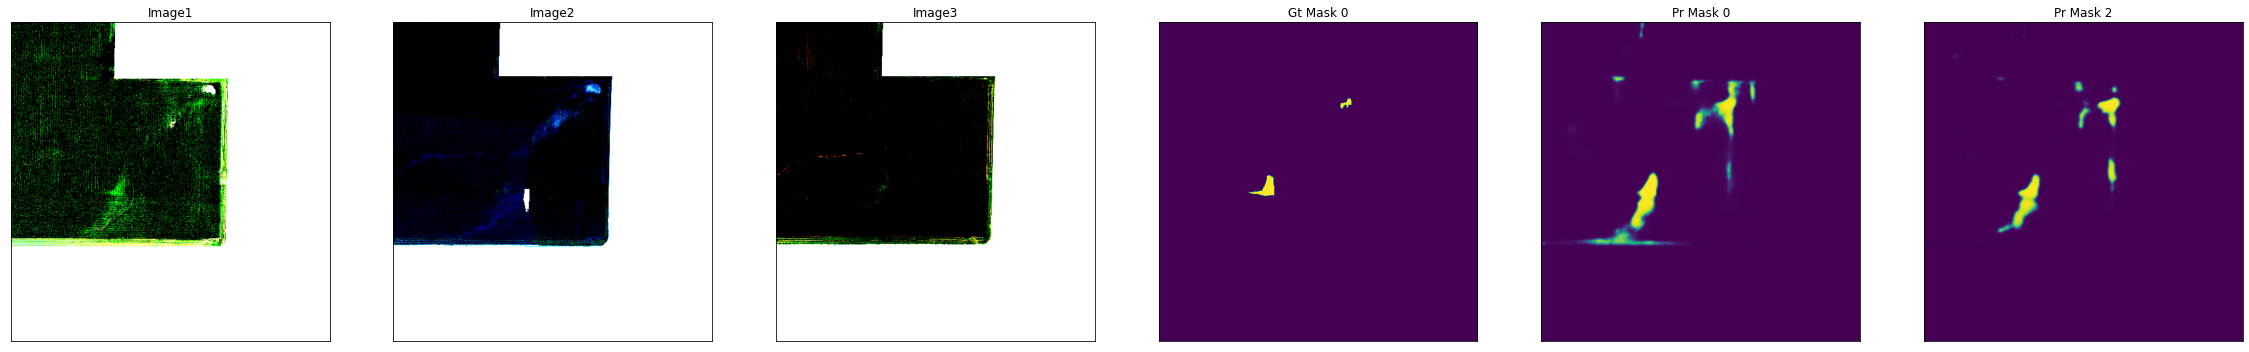

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3W3U46A4H


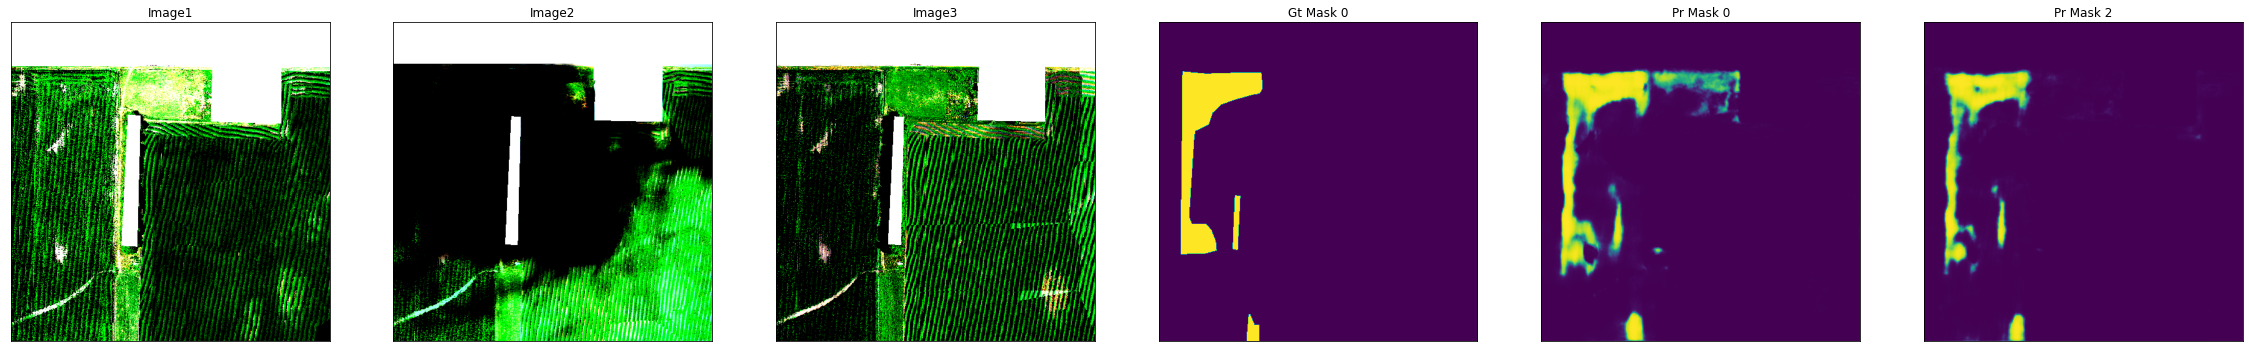

In [18]:
""" MOdel Evaluation """
from keras.models import load_model
test_dataset = Dataset(INPUT,
                       status = 'test',
                classes = Defined_CLASSES,
                augmentation = validation_augmentation(),
                preprocessing = get_preprocessing(preprocess_input),
                
    )

test_dataloader = Dataloader(test_dataset, batch_size=1, shuffle=False)
##model = load_model('/home/ubuntu/Breast Models/best_model_Inception_resnet_v2_175_epoch_all_model.h5', custom_objects={'iou_score':sm.metrics.IOUScore(threshold =0.5), 'f1-score':sm.metrics.FScore(threshold = 0.5),'dice_loss_plus_1focal_loss':sm.losses.DiceLoss(class_weights=np.array([0.1,0.3,0.7,0.9]))+1*sm.losses.CategoricalFocalLoss() })
model2 = sm.Unet(BACK_BONE, classes = n_classes, activation = activation,encoder_weights='imagenet',encoder_freeze = False)

model.load_weights(HOME_DIR+'/Trained_model/Unet_segmentaion_'+BACK_BONE+'_batch_'+str(BATCH_SIZE)+'_epoch_'+str(EPOCHS)+'_3_time_steps_9_channels'+'.h5')
model2.load_weights(HOME_DIR+'/Trained_model/Unet_segmentaion_'+BACK_BONE+'_batch_'+str(BATCH_SIZE)+'_epoch_'+str(EPOCHS)+'_1_time_step_3_channels_rgb_1'+'.h5')


scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))
    
sp =HOME_DIR+'Dataset/predictions/'+BACK_BONE+'_batch_'+str(BATCH_SIZE)+'_epoch_'+str(EPOCHS)+'_3_time_steps_9_channels'+'/'

n = 47
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in range(0,15):
    
    image1, image2, image3,gt_mask, boundary_mask,flight_code = test_dataset[i]
    image = np.concatenate((image1, image2, image3), axis = 2)
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    pr_mask2 = model2.predict(np.expand_dims(image1, axis=0))
    print(flight_code)
    visualize(
        save_status = False,
        save_path = sp,
        flight_code = flight_code,
        image1 = image1,
        image2 = image2,
        image3 = image3,
        #image_0=denormalize(image.squeeze()),
        gt_mask_0=gt_mask[...,0].squeeze(),
        pr_mask_0=pr_mask[...,0].squeeze(),
        pr_mask_2=pr_mask2[...,0].squeeze(),
    ) 
    #visualize(
    #    image_2 = denormalize(image.squeeze()),
    #    gt_mask_tot = denormalize(gt_mask[...,:].squeeze()),
     #   pr_mask_tot = denormalize(pr_mask[...,:].squeeze()),
        
    #)
    #pr_1 = (pr_mask[...,0].squeeze())*0
    #pr_2 = (pr_mask[...,1].squeeze())*1
    #pr_3 = (pr_mask[...,2].squeeze())*2
    #pr_4 = (pr_mask[...,3].squeeze())*3
    #merge_pr = pr_1+pr_2+pr_3+pr_4
    #gt_1 = (gt_mask[...,0].squeeze())*0
    #gt_2 = (gt_mask[...,1].squeeze())*1
    #gt_3 = (gt_mask[...,2].squeeze())*2
    #gt_4 = (gt_mask[...,3].squeeze())*3
    #merge_gt = gt_1+gt_2+gt_3+gt_4
    #visualize(    
    #    image_4=denormalize(image.squeeze()),
    #    gt_mask_4=denormalize(merge_gt),
    #    pr_mask_4=denormalize(merge_pr),
    #)
        
